
# Integración por método de Taylor del modelo de Kermack-McKendrick

In [2]:
include("Taylor.jl")
include("IntegradorKermack.jl")
using ADT
using KMK
using PyPlot
using NLsolve

In [1]:
eps_abs = 1e-30

1.0e-30

El modelo de Kermack-McKendrick es un modelo de ecuaciones diferenciales ordinarias que intenta describir el comportamiento de una población que sufre una enfermedad. Las ecuaciones más sencillas, para una población, son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$

donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados con inmunidad; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

In [25]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

eps_abs = 1e-30

function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

function coefs_1_re(gamma, beta, phi, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    F3(R) = phi*R
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) + F3(Tr)# F1 = -b*S*I + p*R
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) - F3(Tr) # F2 = g*I-p*R

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

function integrador_kermack_re(N, I0, R0, t0, tf, gamma, beta, phi)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    n_iteraciones = 1
    while t0 < tf && n_iteraciones < 500
        
        S,I,R = coefs_1_re(gamma, beta, phi, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
        n_iteraciones += 1
    end
    return t,s,i,r
end

function coefs_SIRS_muerte(γ,β,μ,f,S_0,I_0,R_0,n=50)
    N=S_0+I_0+R_0
    
    s=[S_0]
    i=[I_0]
    r=[R_0]  #inicializar arrays 
    
    F1(S,I,R) = -(β/N)*S*I + μ*(I+R)+f*R #N-S=I+R pues N=I+R+S 
    F2(S,I) = (β/N)*S*I -γ*I -μ*I
    F3(I,R) = γ*I-μ*R-f*R
    
    f1=Taylor(0) #inicializamos f's pues las variables definidas en el for son locales
    f2=Taylor(0)
    f3=Taylor(0)
    
    for k in 1:n
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)

        f1=F1(Ts,Ti,Tr)
        f2=F2(Ts,Ti)
        f3=F3(Ti,Tr)
        
        S_0 = f1.pol[k]/k
        I_0 = f2.pol[k]/k
        R_0 = f3.pol[k]/k
        
        push!(s,S_0)
        push!(r,R_0)
        push!(i,I_0)
           
    end
    
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    
    return s,i,r
end

function integrador_kermack_SIRS_muerte(N, I0, R0, t0, tf, gamma, beta,mu,f,n=50)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_SIRS_muerte(gamma, beta,mu,f, S0, I0, R0,n)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    
    return t,s,i,r
end

integrador_kermack_SIRS_muerte (generic function with 2 methods)

In [3]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);

  0.943375 seconds (14.34 M allocations: 248.543 MB, 2.95% gc time)


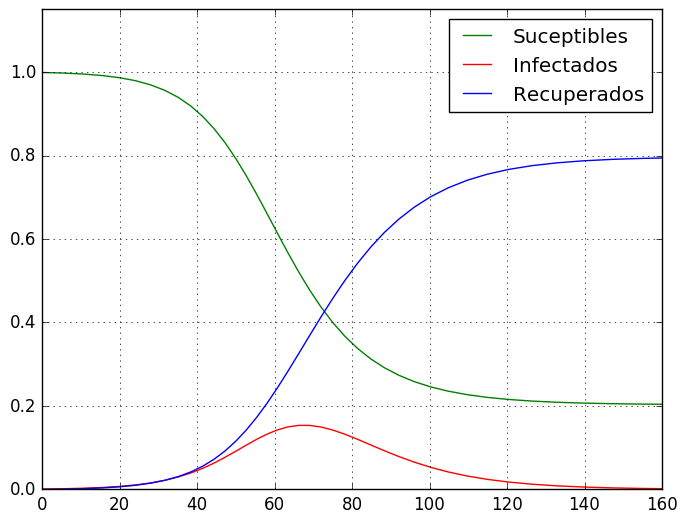

PyObject <matplotlib.legend.Legend object at 0x00000000279B0208>

In [4]:
grafica_1 = figure()
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,160,0,1.15])
grid()
legend()
# show()

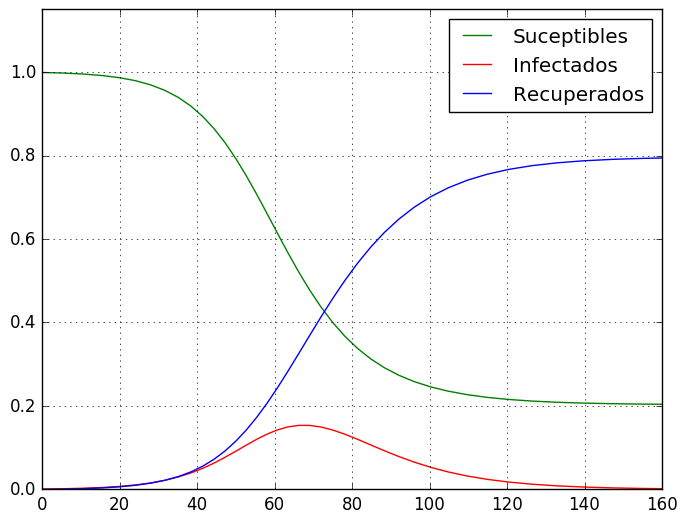

In [5]:
grafica_1

Tomamos como valores una población total $N = 1$, $N/1000$ personas infectadas y 0 recuperadas. También elegimos valores de $\beta = 0.2$ y $\gamma = 0.1$ de acuerdo con la literatura.

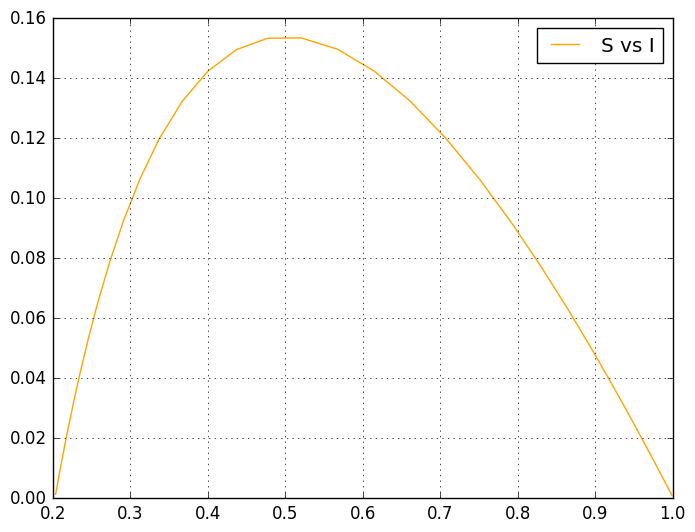

In [29]:
diagrama_fase_1 = figure()
plot(s,i, color = "orange", label = "S vs I")
legend()
grid()

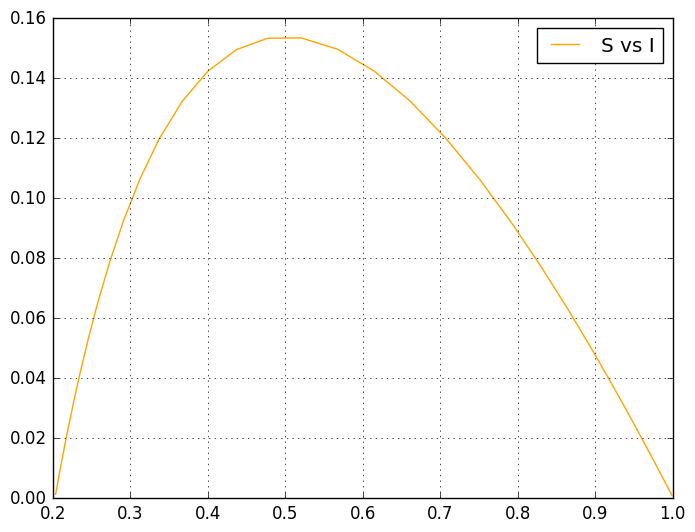

In [30]:
diagrama_fase_1

## Modelo SIRS: Inmunidad temporal o reincidencia
Ahora introducimos un término de reincidencia $\phi$, quedando las ecuaciones como:

$$ \frac{dS}{dt} = -\beta SI + \phi R$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I -\phi R$$


In [31]:
N = 1.
t_inicial = 0.
t_final = 1400.
beta = .5
gamma = .25
phi = 0.005
infectados_iniciales = N/1000
recuperados_iniciales = 0.

@time t,s,i,r = integrador_kermack_re(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta, phi);
length(t)

  2.320503 seconds (72.50 M allocations: 1.167 GB, 3.75% gc time)


204

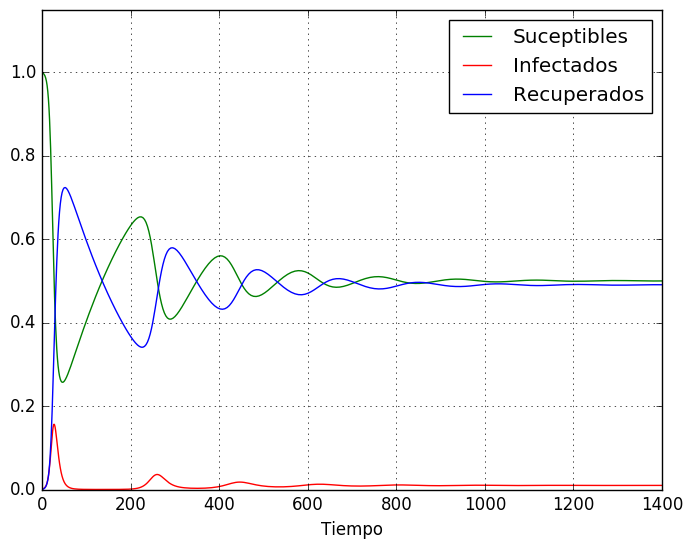

In [32]:
grafica_2 = figure()
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,t_final,0,1.15])
grid()
legend()
xlabel("Tiempo")
;

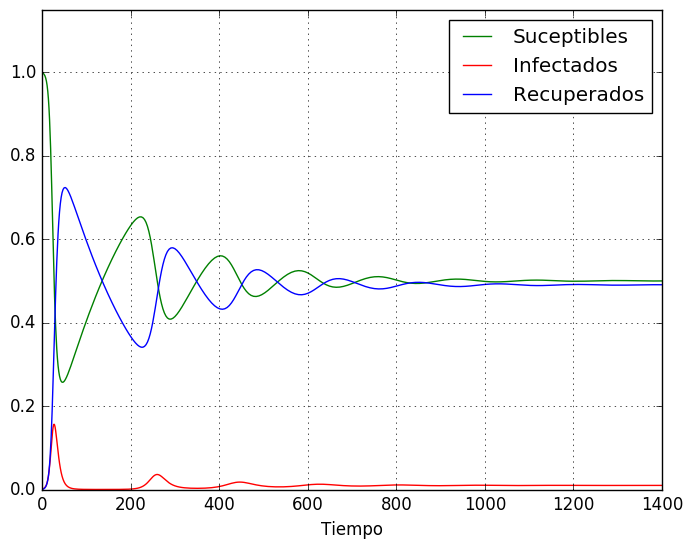

In [33]:
grafica_2

Tomamos como parámetros $\beta = 0.5$, $\gamma = 0.25 y $\phi = 0.005$

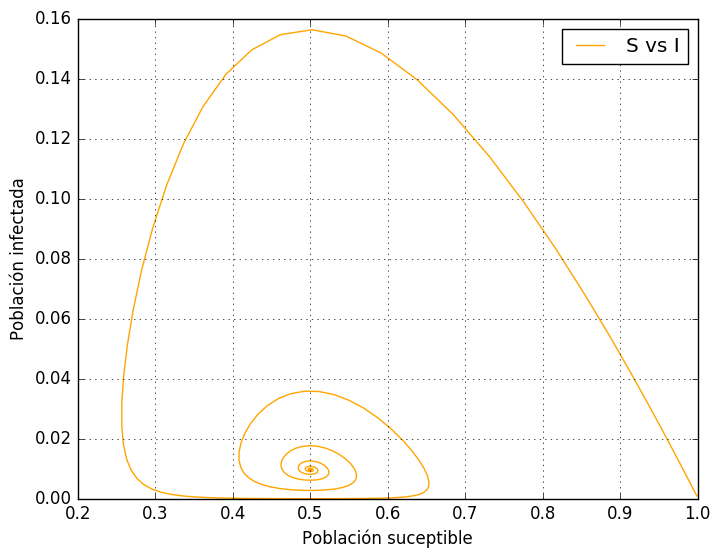

In [35]:
diagrama_fase_2 = figure()
plot(s,i, color = "orange", label = "S vs I")
legend()
xlabel("Población suceptible")
ylabel("Población infectada")
grid()

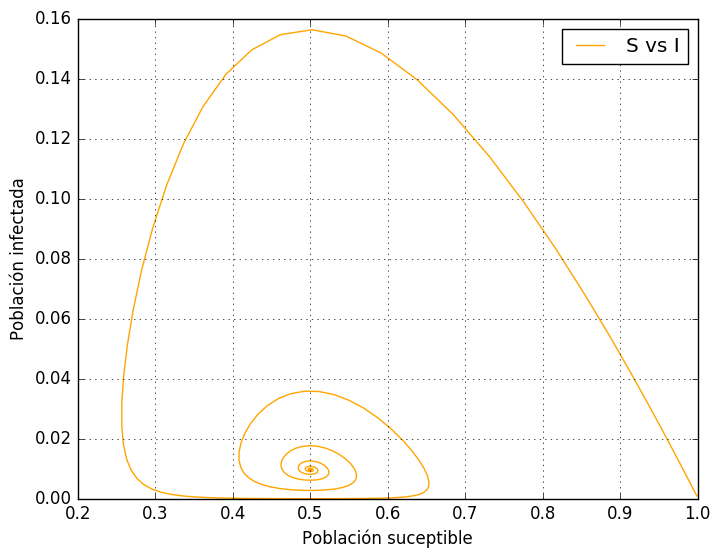

In [36]:
diagrama_fase_2

## Model SIRS con Nacimientos y Muertes
Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad (para mantener la población constante). Con esto, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + \phi R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - \phi R \\
\end{array}



In [89]:
N = 1.
I0 = N/1000
R0 = 0.
S0 = N-I0-R0
ti = 0.
tf = 700.
beta = 0.2
gamma = 0.075
mu = 0.005
f = 0.00135

@time t,s,i,r = integrador_kermack_SIRS_muerte(N, I0, R0, ti, tf, gamma, beta ,mu,f);

  1.845033 seconds (62.38 M allocations: 1.010 GB, 4.77% gc time)


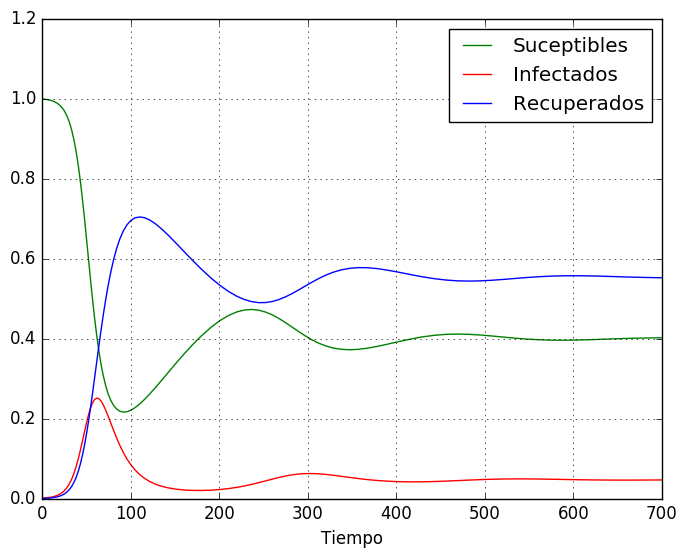

In [90]:
grafica_3 = figure()
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
grid()
xlabel("Tiempo")
axis([0,tf,0,1.2])
legend()
show()

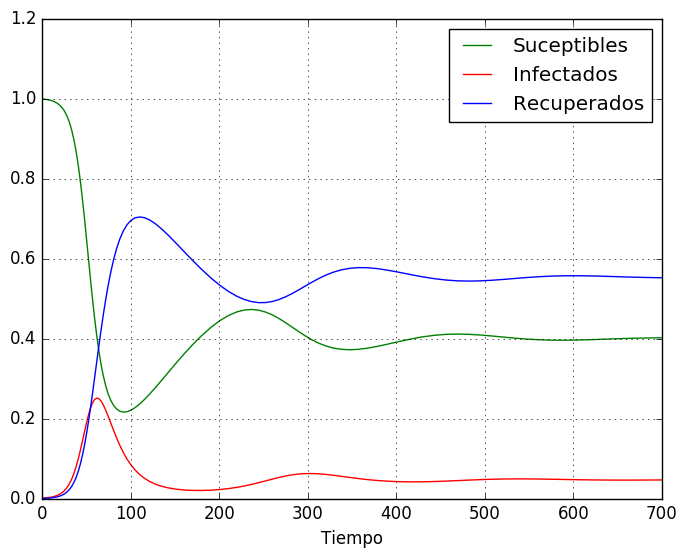

In [91]:
grafica_3

Observamos que bajo las mismas condiciones iniciales (con parámetros $\beta = 0.2$, $\gamma = 0.075$,  $\mu = 0.002$ y $\phi = 0.055$) la dinámica llega a un punto estable.

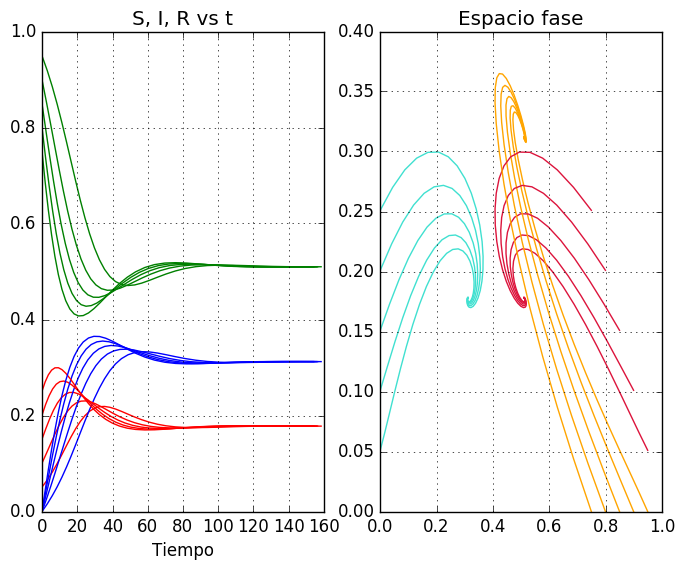

In [49]:
grafica_4 = figure()
for j in 1:5
    
    N = 1.
    I0 = N/1000+0.05*j
    R0 = 0.
    S0 = N-I0-R0
    ti = 0.
    tf = 150.
    beta = 0.2
    gamma = 0.1
    mu = 0.002
    f = 0.055


    @time t,s,i,r = integrador_kermack_SIRS_muerte(N, I0, R0, ti, tf, gamma, beta, mu, f);

    subplot(1,2,1)
    plot(t,s, color = "green", label = "Suceptibles")
    plot(t,i, color = "red", label = "Infectados")
    plot(t,r, color = "blue", label = "Recuperados")
    grid()
    
    title("S, I, R vs t")
    xlabel("Tiempo")
    
    subplot(1,2,2)
    plot(s,i, color="crimson")
    plot(s,r,color="orange")
    plot(r,i,color="turquoise")
    grid()
    
    
    title("Espacio fase")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
end

Veamos qué pasa variando un poco nuestras condiciones iniciales. (misma guía de colores)

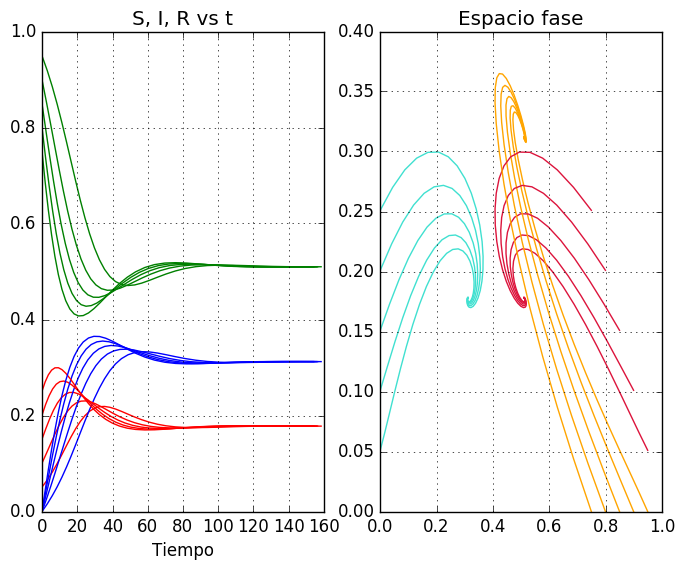

In [50]:
grafica_4

# Modelo SIR para varias especies

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.
